In [161]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()


import re
import string

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

##  With aditional labeled as hate speech data and API Requests we were able to get more twits and balance main dataset.
###  The code for requests and balansing can be found in data_collection.ipynb

# Load Corpus and Look at the Data

In [162]:
df = pd.read_csv("../data/balanced_data_combined.csv")
df = df.drop(columns = 'Unnamed: 0')

In [163]:
df.shape

(8337, 2)

In [164]:
df.head()

,text,class
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [165]:
# class 0 - not hate speech
# class 1 - hate speech

In [166]:
# Crreate class description for each row in data
df['class_descr'] = df['class'].map(lambda x: 'hate_speech' if x==1 else 'not_hate_speech')

In [167]:
df['class'].value_counts()

1    4174
0    4163
Name: class, dtype: int64

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8335 non-null   object
 1   class        8337 non-null   int64 
 2   class_descr  8337 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.5+ KB


In [169]:
# Drop NaN values in text column

df.dropna(subset=['text'], inplace=True)

# Visualize class imbalance

1    0.50054
0    0.49946
Name: class, dtype: float64


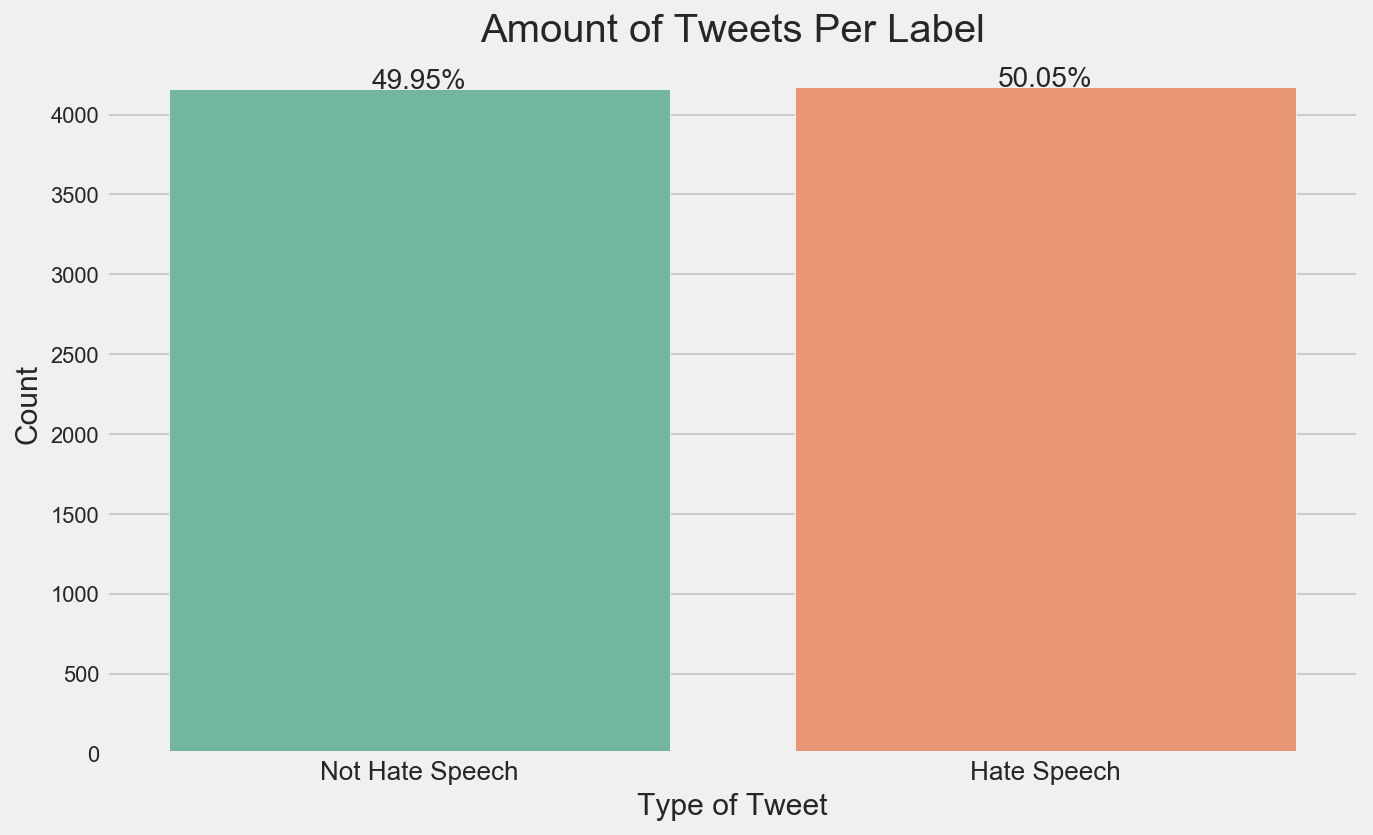

In [170]:
print(df['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

# Create Document - Term Matrix

* Preprotcessing and cleaning 
* Tokenize
* Stemming and Lemming
* Document-Term Matrix

## Data Preprotcessing and Cleaning

In [171]:
# removing excess
# removing punctuation
# lovercase letters 
# remove numbers or numerical values
# remove non-sesial text (/n)

In [172]:
# Create function with text cleaning techniques usinx regex

def clean_text_step1(text):
    '''
    Looking for speciffic patterns in the text and 
    removing them or replacing with space
    Function returns string
    '''
        
    # make text lowercase
    text = text.lower()
    
    # string punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # removing patterns and replace it with nothing
    text = re.sub('\[.*?\]', '', text)
 
    # removing digits if they surounded with text or digit
    text = re.sub('\w*\d\w*', '', text)
    
    # make just 1 space if there is more then 1
    text = re.sub('\s+', ' ', text)
    
    # replace new line symbol with space
    text = re.sub('\n', ' ', text)
    
    # removing any quotes
    text = re.sub('\"+', '', text)
    
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    
    # cleaning from user name
    text = re.sub('(@[^\s]+)', '', text)
    
    # looking for # and replacing it
    text = re.sub('(#[^\s]+)', '', text)
    
    # removing `rt`
    text = re.sub('(rt)', '', text)

    # looking for `httptco`
    text = re.sub('(httptco)', '', text)
    
    # looking for `mkr`
    text = re.sub('(mkr)', '', text)
    
    text = re.sub('(sexist)', '', text)
    
    text = re.sub('(like)', '', text)
    
    text = re.sub('(women)', '', text)

    return text

In [173]:
# applying function for cleaning text data

df['text'] = df['text'].apply(clean_text_step1)

In [174]:
df.head()

,text,class,class_descr
0,drasko they didnt cook half a bird you idiot,1,hate_speech
1,hopefully someone cooks drasko in the next ep of,1,hate_speech
2,of course you were born in serbiayoure as fuck...,1,hate_speech
3,these girls are the equivalent of the irritati...,1,hate_speech
4,yesyoureracist at least youre only a tiny bit...,1,hate_speech


In [175]:
# Function to filter data with words that contain more then 2 characters
def txt_filtering(row, n =2):
    new_words = []
    for w in row['text'].split(' '):
        if len(w) > 2:
            new_words.append(w)
    row['text'] = ' '.join(new_words)
    return row

In [176]:
df = df.apply(txt_filtering, axis = 1)

## Tokenization Data (splitting into smaller pieces) and removing stopwords

In [177]:
stopwords_list = stopwords.words('english')

In [178]:
def tokenize_text(text):
    
    """
    Tocanize document and create visualization of most recent words
    Wiil filter data with stopwords
    """
    tokens = nltk.word_tokenize(text)
    
    stopwords_removed = [token for token in tokens if token not in stopwords_list] 
    
    return stopwords_removed

In [179]:
processed_data = list(map(tokenize_text, df['text']))

## Lets Plot frequency distribution of tokens in corpus

In [180]:
def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for tweet in data:
        for word in tweet:
            words_lst.append(word)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30, title = "Frequency distribution of words within corpus")
    plt.show()

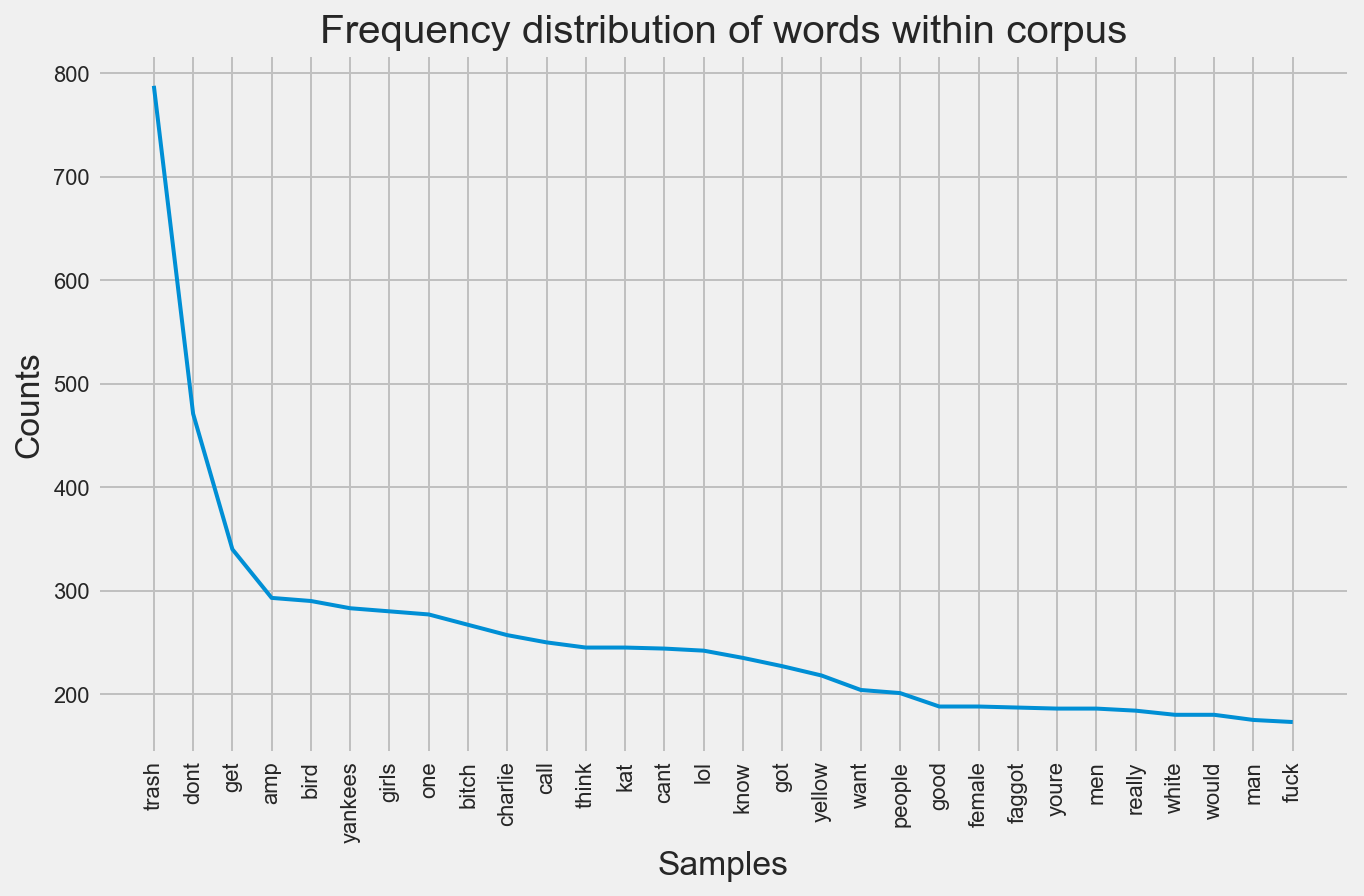

In [181]:
plot_frequency(processed_data)

In [182]:
processed_data[:2]

[['drasko', 'didnt', 'cook', 'half', 'bird', 'idiot'],
 ['hopefully', 'someone', 'cooks', 'drasko', 'next']]

In [183]:
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

17984

## Create Docunent-Term Matrix

In [184]:
# look at the corpus
df.head()

,text,class,class_descr
0,drasko they didnt cook half bird you idiot,1,hate_speech
1,hopefully someone cooks drasko the next,1,hate_speech
2,course you were born serbiayoure fucked serbia...,1,hate_speech
3,these girls are the equivalent the irritating ...,1,hate_speech
4,yesyoureracist least youre only tiny bit racis...,1,hate_speech


In [185]:
# Using CountVextorizer from sklearn 
# in data_dtm each row represents different document
# and each collumn represents word from vocab

cv = CountVectorizer(stop_words = 'english')
df_cv = cv.fit_transform(df.text)
data_dtm = pd.DataFrame(df_cv.toarray(), columns= cv.get_feature_names())
data_dtm.index = df.index
data_dtm.head()

,aaaaaaaaand,aaand,aamaadmipay,aamattyhealy,aamessinger,aan,aandapples,aap,aarcayne,aaron,...,zstonecipher,ztsupreme,zucchini,zwaaad,zwithr,zyhosbrfff,zzachbarness,zzzquil,zzzz,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Lematizing Data

In [186]:
# function to creat a list with all lemmatized words

def lematizing_text(data):
    
    """
    Lematizing words from the corpus data
    Returns list of strings with lematized 
    words in each string
    """
    
    lemmatizer = WordNetLemmatizer() 
    lemmatized_output = []

    for tweet in data:
        lemmed = ' '.join([lemmatizer.lemmatize(w) for w in tweet])
        lemmatized_output.append(lemmed)
        
    return lemmatized_output

In [187]:
lemmatized_data = lematizing_text(processed_data)

In [188]:
lemmatized_data[:5]

['drasko didnt cook half bird idiot',
 'hopefully someone cook drasko next',
 'course born serbiayoure fucked serbian film',
 'girl equivalent irritating asian girl couple year ago well done',
 'yesyoureracist least youre tiny bit racist racist dick']

## Most Frequent Words for Each Class

In [189]:
df_freq_hate = df[df['class']==1]
df_freq_not_hate = df[df['class']==0]

In [190]:
data_hate = df_freq_hate['text']
data_not_hate = df_freq_not_hate['text']

In [191]:
def freq_wrds_class(data, n = 20, show= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(map(tokenize_text, data))
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if show:
        print('Total words in vocab : {}'.format(len(total_vocab)))
        print (30*'-')
        print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        return freq.most_common(n)
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    
    return freq

In [192]:
# Top 20 hate words:
freq_wrds_class(data_hate, show=True)

Total words in vocab : 9703
------------------------------
Top 20 most frequent words:


[('dont', 302),
 ('bitch', 257),
 ('girls', 245),
 ('kat', 244),
 ('call', 210),
 ('get', 196),
 ('faggot', 187),
 ('think', 178),
 ('female', 176),
 ('fuck', 173),
 ('cant', 170),
 ('men', 165),
 ('ass', 152),
 ('one', 147),
 ('know', 146),
 ('nigga', 139),
 ('woman', 137),
 ('white', 133),
 ('fucking', 132),
 ('hate', 128)]

In [193]:
# Top 20 non-hate words:
freq_wrds_class(data_not_hate)

Total words in vocab : 11672
------------------------------
Top 20 most frequent words:


[('trash', 672),
 ('bird', 287),
 ('yankees', 281),
 ('charlie', 257),
 ('yellow', 213),
 ('dont', 169),
 ('birds', 167),
 ('amp', 166),
 ('get', 144),
 ('lol', 140),
 ('got', 131),
 ('one', 130),
 ('monkey', 111),
 ('ghetto', 109),
 ('colored', 108),
 ('good', 94),
 ('know', 89),
 ('new', 88),
 ('love', 84),
 ('day', 84)]

## Normalized word frequencies:

In [194]:
def normalized_word_fqncy(data, n=25):
    
    frqncy = freq_wrds_class(data, n, show = False)
    total_w_count = sum(frqncy.values())
    top = frqncy.most_common(25)
    print("Word \t\t Normalized Frequency")
    print()
    for word in top:
        normalized_frequency = word[1]/total_w_count
        print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [195]:
normalized_word_fqncy(data_hate)

Word 		 Normalized Frequency

dont 		 0.009045
bitch 		 0.007697
girls 		 0.007338
kat 		 0.007308
call 		 0.006289
get 		 0.00587
faggot 		 0.005601
think 		 0.005331
female 		 0.005271
fuck 		 0.005181
cant 		 0.005091
men 		 0.004942
ass 		 0.004552
one 		 0.004403
know 		 0.004373
nigga 		 0.004163
woman 		 0.004103
white 		 0.003983
fucking 		 0.003953
hate 		 0.003834
amp 		 0.003804
youre 		 0.003684
want 		 0.003624
people 		 0.003594
trash 		 0.003474


In [196]:
normalized_word_fqncy(data_not_hate)

Word 		 Normalized Frequency

trash 		 0.01933
bird 		 0.008254
yankees 		 0.008081
charlie 		 0.007391
yellow 		 0.006126
dont 		 0.00486
birds 		 0.004803
amp 		 0.004774
get 		 0.004141
lol 		 0.004026
got 		 0.003768
one 		 0.003739
monkey 		 0.003192
ghetto 		 0.003135
colored 		 0.003106
good 		 0.002703
know 		 0.00256
new 		 0.002531
love 		 0.002416
day 		 0.002416
game 		 0.002387
want 		 0.002387
make 		 0.002358
would 		 0.00233
people 		 0.00233


# Visualization

In [197]:
# Seperate frequency of each class

hate_freq = freq_wrds_class(data_hate, show =False)
not_hate_freq = freq_wrds_class(data_not_hate, show =False)

In [198]:
# create counts of hate and not hate with values and words

hate_bar_counts = [x[1] for x in hate_freq.most_common(25)]
hate_bar_words = [x[0] for x in hate_freq.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(25)]

In [199]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.8,.16, 30))

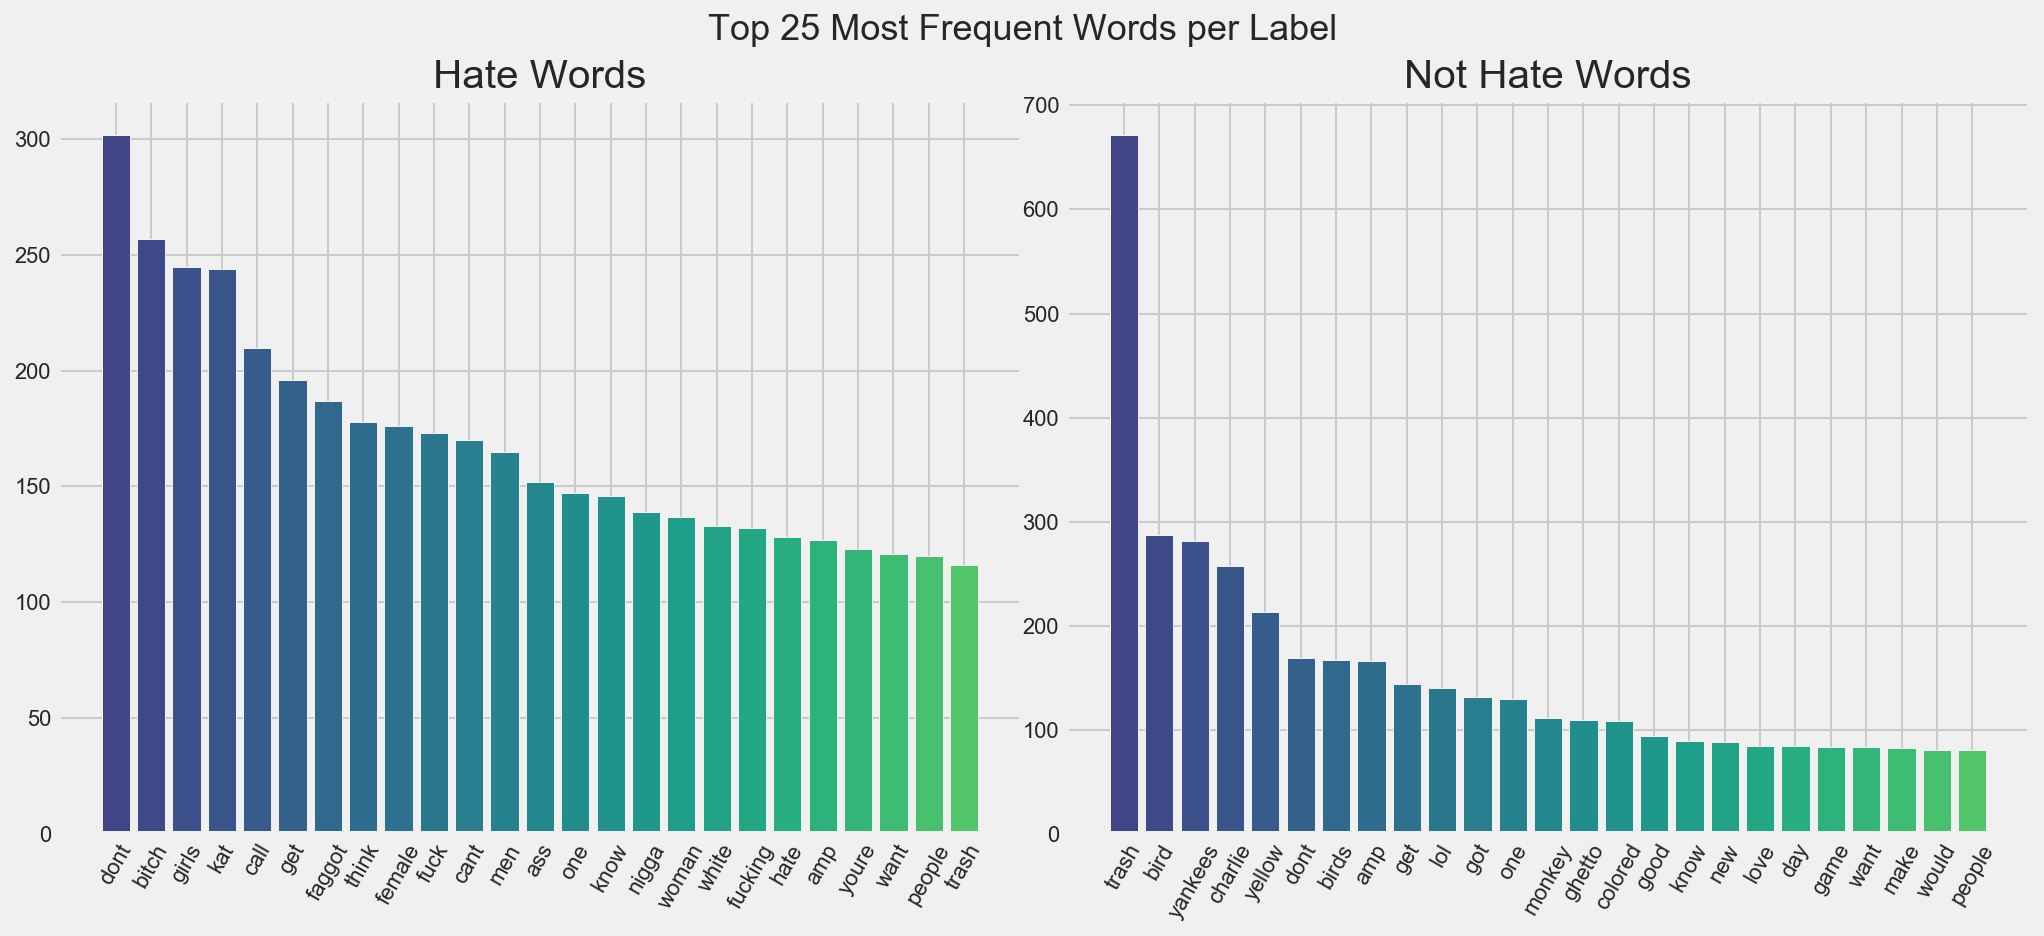

In [244]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Words')
ax2.title.set_text('Not Hate Words')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)
new_figure.suptitle('Top 25 Most Frequent Words per Label', fontsize =18, y =1.05)

# plt.savefig('../images/word_count_graphs.png')

plt.show()

# Create Word Clouds

In [201]:
hate_dictionary = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dictionary = dict(zip(not_hate_bar_words, not_hate_bar_counts))

In [317]:
def wordcloud(dic, save = False, name = None):
    
    
    wordcloud = WordCloud(colormap='Spectral', background_color='mintcream').generate_from_frequencies(dic)

    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(8,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    # plt.title('Hate Speech Word Cloud', color = "w")
    if save :
        #plt.savefig('../images/{}_wordcloud.png'.format(name))
        plt.show()
    return

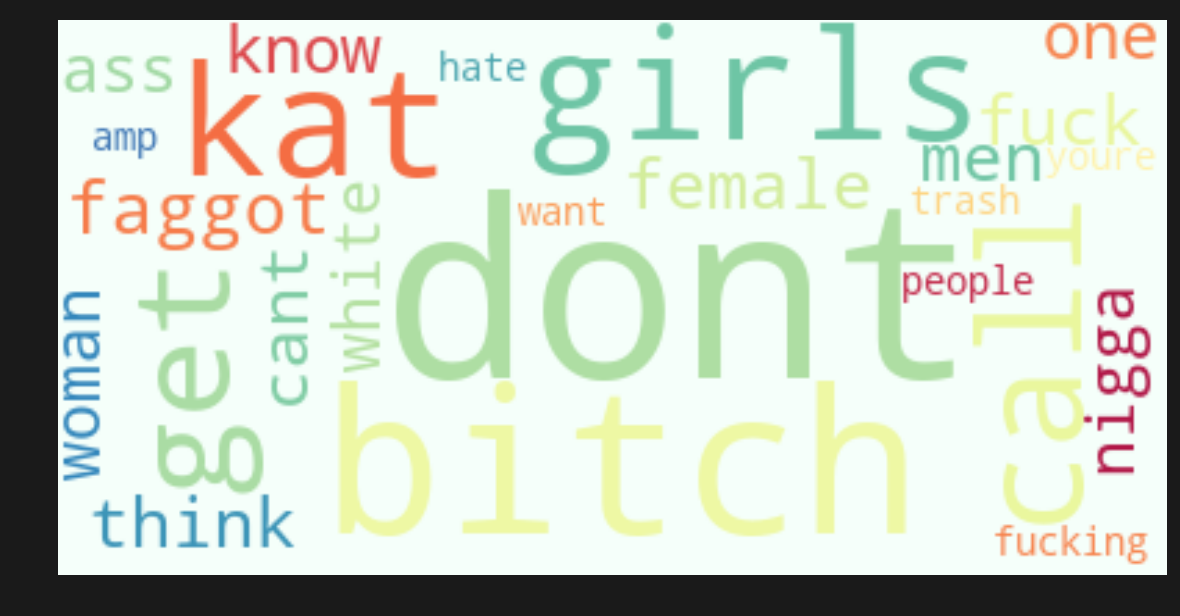

In [318]:
wordcloud(hate_dictionary, save = True, name = 'hate_speech')

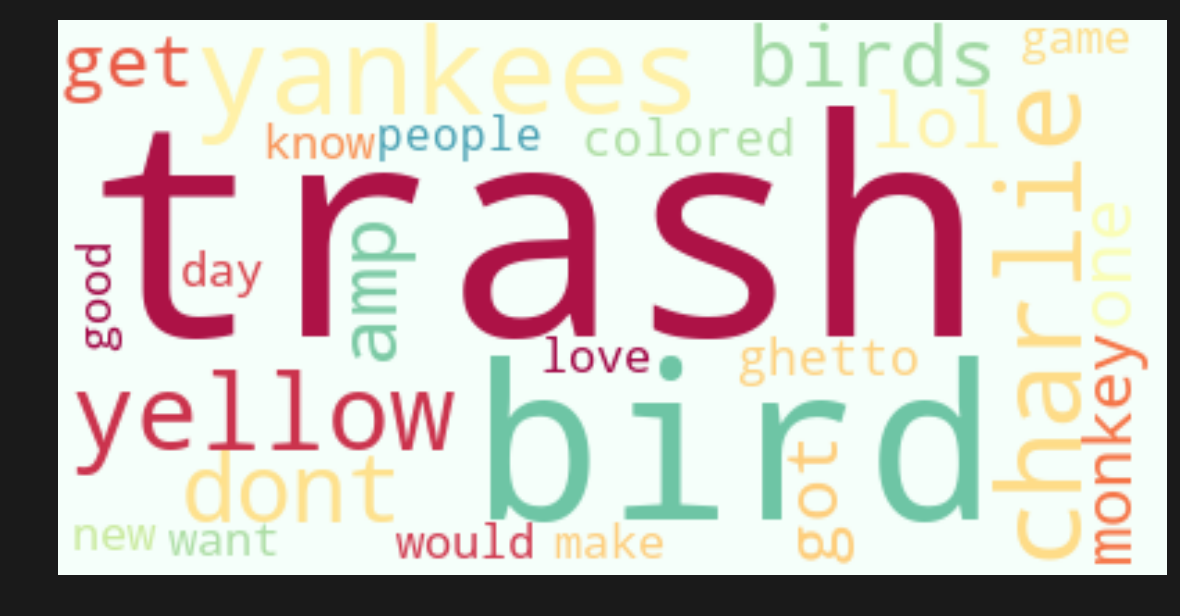

In [319]:
wordcloud(not_hate_dictionary, save = True, name = 'not_hate_speech')

## Checking unique words in both classes

In [205]:
hate_wocab = freq_wrds_class(data_hate, n = 9703)

Total words in vocab : 9703
------------------------------
Top 9703 most frequent words:


In [206]:
not_hate_wocab = freq_wrds_class(data_not_hate, n = 11672)

Total words in vocab : 11672
------------------------------
Top 11672 most frequent words:


In [207]:
hate_words = [t[0] for t in hate_wocab]
not_hate_words = [t[0] for t in not_hate_wocab]

In [208]:
exclusive_hate_wrds = [w for w in hate_words if w not in not_hate_words]
print(len(exclusive_hate_wrds))

6312


In [320]:
exclusive_hate_wrds[:10]

['faggot',
 'fuck',
 'nigga',
 'fucking',
 'niggas',
 'bitches',
 'feminists',
 'niggers',
 'yesyoure',
 'feminist']

In [322]:
len(set(exclusive_hate_wrds))

6312

As we can see a majority of hate speech words are racist, sexist and homophobic slurs that exceed cultural slang. The fact that these words are unique to the "Hate Speech" label affirm that it's indeed hate speech that should be flagged and taken down.

## Visualizing Unique Words with Venn Diagram

In [323]:
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

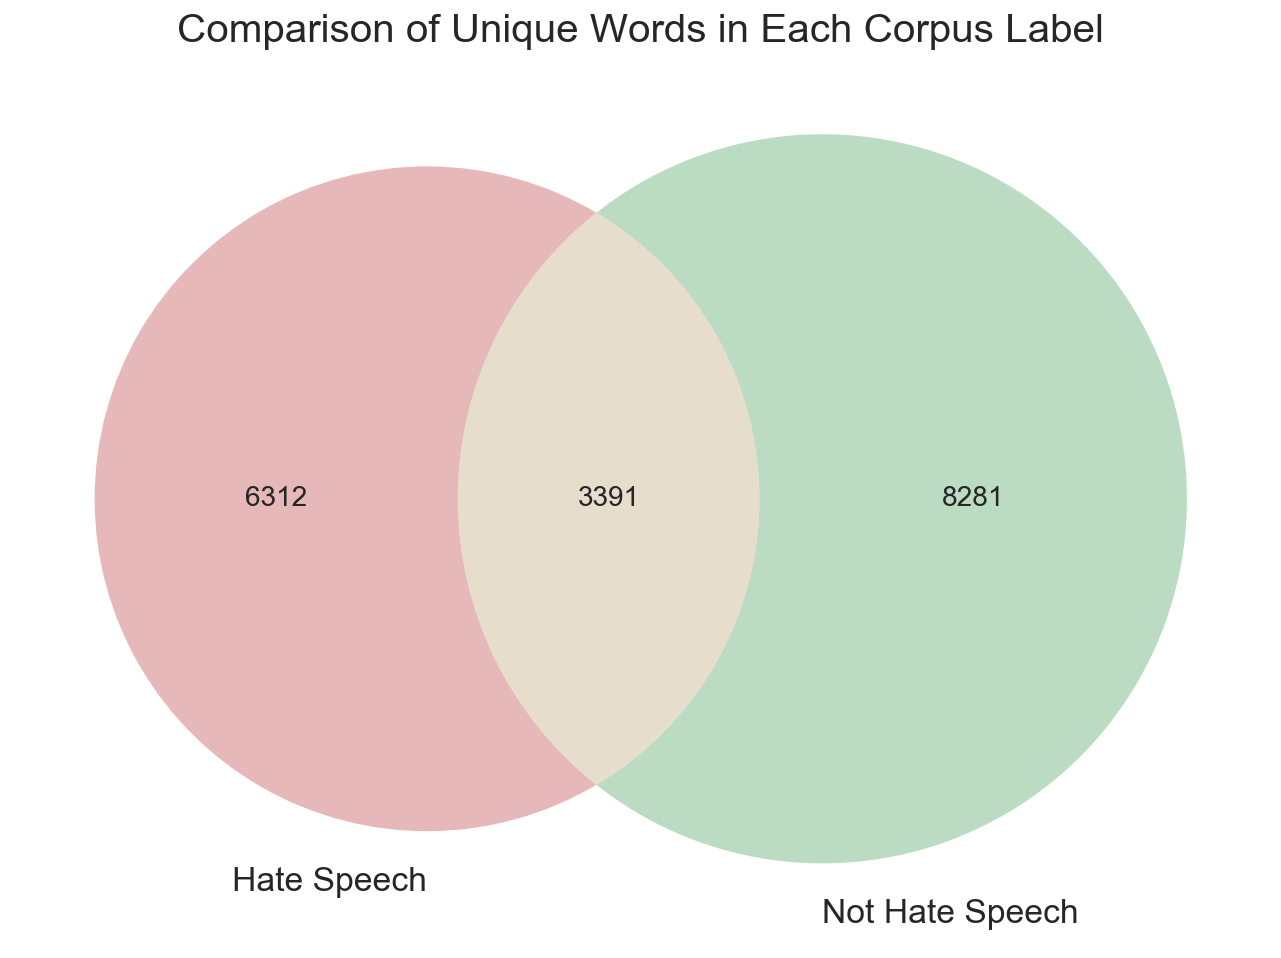

In [324]:
plt.figure(figsize=(10,10), facecolor='w')
venn2([set(hate_words), set(not_hate_words)], set_labels = ('Hate Speech', 'Not Hate Speech'))
plt.title('Comparison of Unique Words in Each Corpus Label')
# plt.savefig('../images/venn.png')
plt.show()

# Create Baseline Models 

## TF-IDF Vectorization

In [212]:
X_lem = lemmatized_data
y_lem = df['class']

In [213]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()  # can add unigram , add stop words possible

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)  # make sure in train
tfidf_data_test_lem = tfidf.transform(X_test_lem)   # make sure on test

tfidf_data_train_lem

<6668x14428 sparse matrix of type '<class 'numpy.float64'>'
	with 53078 stored elements in Compressed Sparse Row format>

In [214]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Tweets: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Tweets: 7.960107978404319
Percentage of columns containing ZERO: 0.9994482874980313


### 99.9% of the columns contain a zero, meaning that's a very sparse matrix

In [215]:
# Lets Keep All models Results in dictionary for future visualization
eval_metrics_dict = {}

## Random Forest Baseline

In [216]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [217]:
rf_precision = precision_score(y_test_lem, rf_test_preds_lem)
rf_recall = recall_score(y_test_lem, rf_test_preds_lem)
rf_acc_score = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(rf_precision))
print('Recall: {:.4}'.format(rf_recall))

print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.854
Recall: 0.9285
Testing Accuracy: 0.886
F1 Score: 0.8897


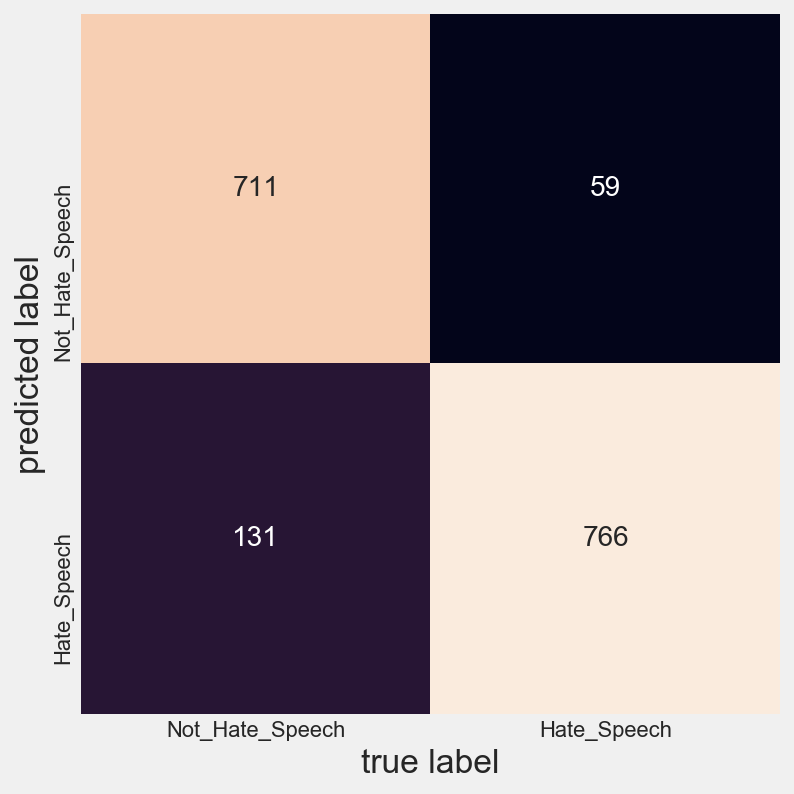

In [218]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [219]:
eval_metrics_dict['Random Forest Baseline'] = {'precision' : '{:.4}'.format(rf_precision), 'recall': '{:.4}'.format(rf_recall), 'f1-score': '{:.4}'.format(rf_f1_score) }

## Logistic Regression Baseline

In [220]:
logreg = LogisticRegression(random_state = 32)
logreg.fit(tfidf_data_train_lem, y_train_lem)
logreg_test_preds = logreg.predict(tfidf_data_test_lem)

In [221]:
log_precision = precision_score(y_test_lem, logreg_test_preds)
log_recall = recall_score(y_test_lem, logreg_test_preds)
log_acc_score = accuracy_score(y_test_lem, logreg_test_preds)
log_f1_score = f1_score(y_test_lem, logreg_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(log_precision))
print('Recall: {:.4}'.format(log_recall))

print("Testing Accuracy: {:.4}".format(log_acc_score))
print("F1 Score: {:.4}".format(log_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.9064
Recall: 0.8921
Testing Accuracy: 0.901
F1 Score: 0.8992


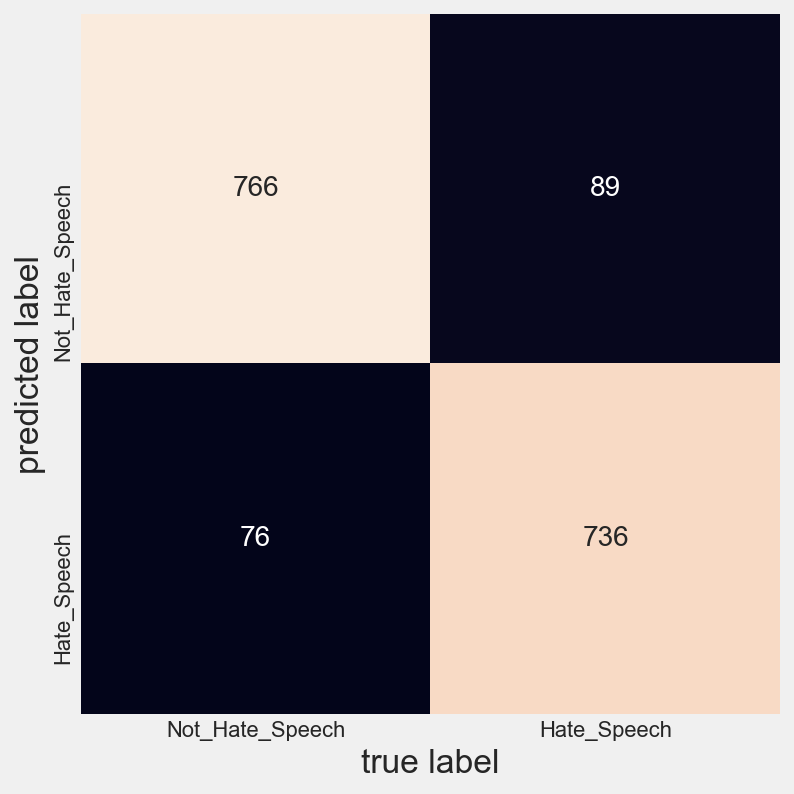

In [222]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [223]:
eval_metrics_dict['Logistic Regression Baseline'] = {'precision' : '{:.4}'.format(log_precision), 'recall': '{:.4}'.format(log_recall), 'f1-score': '{:.4}'.format(log_f1_score) }

## Naive Bayes Baseline

In [224]:
nb = MultinomialNB()
nb.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds = nb.predict(tfidf_data_test_lem)

In [225]:
nb_precision = precision_score(y_test_lem, nb_test_preds)
nb_recall = recall_score(y_test_lem, nb_test_preds)
nb_acc_score = accuracy_score(y_test_lem, nb_test_preds)
nb_f1_score = f1_score(y_test_lem, nb_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(nb_precision))
print('Recall: {:.4}'.format(nb_recall))

print("Testing Accuracy: {:.4}".format(nb_acc_score))
print("F1 Score: {:.4}".format(nb_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.8756
Recall: 0.9212
Testing Accuracy: 0.8962
F1 Score: 0.8978


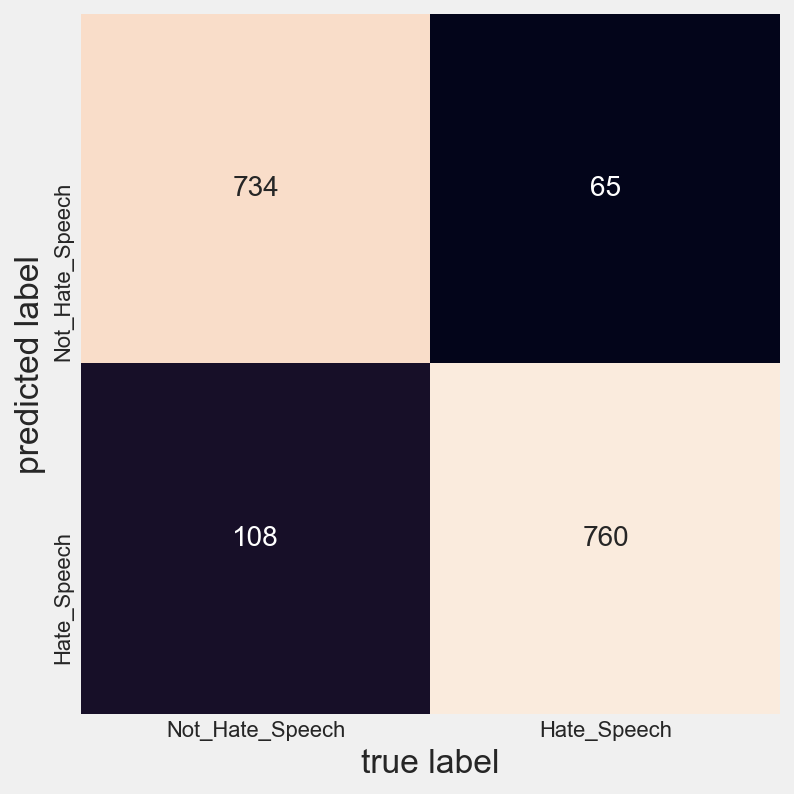

In [226]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, nb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [227]:
eval_metrics_dict['Naive Bayes Baseline'] = {'precision' : '{:.4}'.format(nb_precision), 'recall': '{:.4}'.format(nb_recall), 'f1-score': '{:.4}'.format(nb_f1_score) }

In [228]:
baseline_results = pd.DataFrame(eval_metrics_dict).T

In [229]:
baseline_results

,precision,recall,f1-score
Random Forest Baseline,0.854,0.9285,0.8897
Logistic Regression Baseline,0.9064,0.8921,0.8992
Naive Bayes Baseline,0.8756,0.9212,0.8978


## As our major evaluation metrics will be Recall and F1 score, based on models perfomance - best results was achived with Random Forest Model

# Tuning Model

In [230]:
from sklearn.model_selection import GridSearchCV

In [231]:
# Number of trees in random forrest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num =5)]

# number of features to consider at each split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [2,4]

# min number of samples required to splid the node
min_samples_split =[2,5]

# min number of samples required at each leaf node
min_samples_leaf =[1,2]

#Method of selecting samples for training each tree
bootstrap =[True,False]

In [232]:
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_split' : min_samples_split,
             'min_samples_leaf' : min_samples_leaf,
             'bootstrap' : bootstrap }
param_grid

{'n_estimators': [50, 62, 75, 87, 100],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2],
 'bootstrap': [True, False]}

In [233]:
rf_momdel = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf_momdel, param_grid = param_grid, cv = 3, verbose = 3, n_jobs = 4, scoring = 'recall' )

In [234]:
rf_grid.fit(tfidf_data_train_lem, y_train_lem)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 62, 75, 87, 100]},
             scoring='recall', verbose=3)

In [235]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [236]:
rf_clf_tunned = RandomForestClassifier(n_estimators = 75, bootstrap=True, max_depth = 2, max_features = 'sqrt', min_samples_split=5)
rf_clf_tunned.fit(tfidf_data_train_lem, y_train_lem)
t_rf_test_preds_lem = rf_clf_tunned.predict(tfidf_data_test_lem)

In [237]:
t_rf_precision = precision_score(y_test_lem, t_rf_test_preds_lem)
t_rf_recall = recall_score(y_test_lem, t_rf_test_preds_lem)
t_rf_acc_score = accuracy_score(y_test_lem, t_rf_test_preds_lem)
t_rf_f1_score = f1_score(y_test_lem, t_rf_test_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision))
print('Recall: {:.4}'.format(t_rf_recall))

print("Testing Accuracy: {:.4}".format(t_rf_acc_score))
print("F1 Score: {:.4}".format(t_rf_f1_score))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.7124
Recall: 0.937
Testing Accuracy: 0.7816
F1 Score: 0.8094


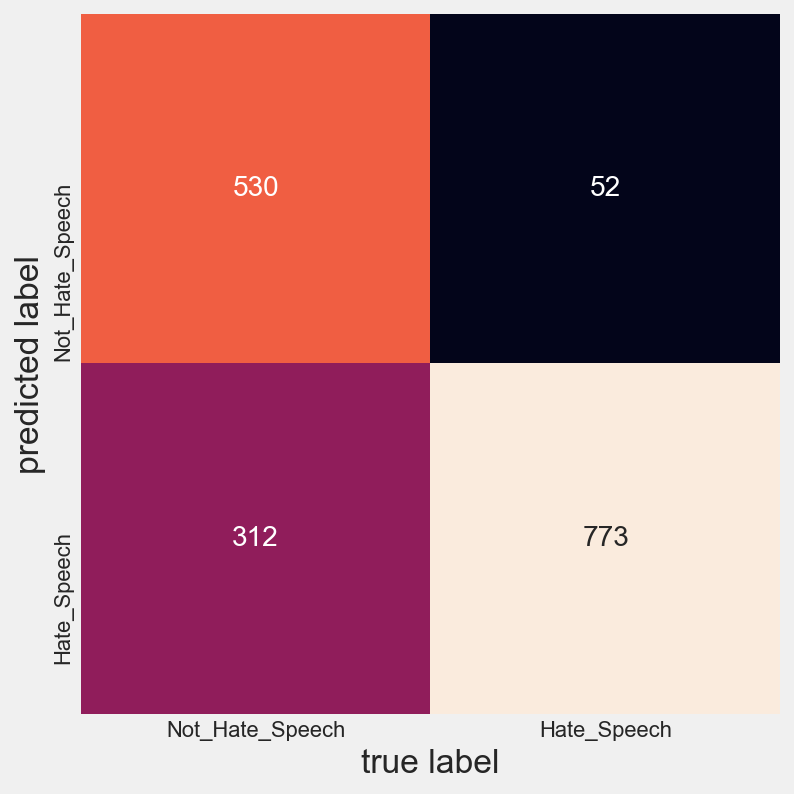

In [330]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, t_rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('../images/matrix.png')

In [238]:
t_rf_train_preds_lem = rf_clf_tunned.predict(tfidf_data_train_lem)

t_rf_precision_train = precision_score(y_train_lem, t_rf_train_preds_lem)
t_rf_recall_train = recall_score(y_train_lem, t_rf_train_preds_lem)
t_rf_acc_score_train = accuracy_score(y_train_lem, t_rf_train_preds_lem)
t_rf_f1_score_train = f1_score(y_train_lem, t_rf_train_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision_train))
print('Recall: {:.4}'.format(t_rf_recall_train))

print("Training Accuracy: {:.4}".format(t_rf_acc_score_train))
print("F1 Score: {:.4}".format(t_rf_f1_score_train))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.7316
Recall: 0.9495
Training Accuracy: 0.7998
F1 Score: 0.8264


In [ ]:
# generating normalized confusion matrix
rf_conf_matrix = plot_confusion_matrix(count_log_reg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logistic Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/normalized_log_reg_countvec_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()